# Finding the genre of a movie based on its synopsis (NLP - Python - LR)

In this notebook, I will develop a text classification model with multiple outputs. For that, I will analyze a textual synopsis and predicts multiple labels/genres associated with it. 

Before to start a short reminder about multi-label classification:
The difference between a multi-class classification problem and a multi-label classification is that in multi-class classification problem, an instance or a record can belong to one and only one of the multiple output classes. For instance, in our case a movie could be either "action", "comedy", or "adventure". But it could not be both "action" and "comedy" at the same time. On the other hand in multi-label classification problems, an instance can have multiple outputs at the same time.

### Summary of Results

#### Method used
We can’t use supervised classification algorithms directly on a multi-label dataset. 

Therefore, we’ll first have to transform our target variable. we will use the Binary Relevance approach to transform our target variable, y.

<img src=https://cdn.analyticsvidhya.com/wp-content/uploads/2019/04/img_4.png width="150" length="150">


We will first take out the unique labels in our dataset:

    Unique labels = [ t1, t2, t3, t4, t5 ]

There are 5 unique tags in the data. Next, we need to replace the current target variable with multiple target variables, each belonging to the unique labels of the dataset. Since there are 5 unique labels, there will be 5 new target variables with values 0 and 1 as shown below:

<img src=https://cdn.analyticsvidhya.com/wp-content/uploads/2019/04/img_5.png width="400" length="400">


#### Technologies used:
- One-hot encoding genre by using sklearn’s MultiLabelBinarizer()
- Converting text inputs into integer by using the sklearn's TF-IDF feature extraction method
- Using a Logistic regresion model

#### Evaluation:

- F1 metric: 0.43 with a 0,5 threshold
- F1 metric: 0.55 with a 0,3 threshold

If we compare with the values obtained by [SPANDAN MADAN](https://spandan-madan.github.io/DeepLearningProject/) in his tutorial, our model has a decent evaluation metric.

#### Conclusion
Our model seems to be working. By improving the data preprocessing step and by decreasing the genre number close to 20, I think we can have better evaluation metric.
We'll try to use a deep learning approach on this same dataset to compare results.



## About the dataset
I will use the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) open dataset for this project. You can download the dataset directly from [this link](http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz).

This dataset contains multiple files, but the focus will be on only two of them for now:

- movie.metadata.tsv: Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. The movie genre tags are available in this file
- plot_summaries.txt: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the plot summary

Let's now import the required libraries and load the dataset into our application

In [1]:
#import lib
import pandas as pd
import numpy as np
import json
import nltk #Natural Language Toolkit
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline


In [2]:
#load data
df= pd.read_csv("MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
df=df
# add column names to the aforementioned three variables
df.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
df.head(2)

movie_id          1                                         movie_name  \
0    975900  /m/03vyhn                                     Ghosts of Mars   
1   3196793  /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   

            3           4     5                                   6  \
0  2001-08-24  14010832.0  98.0  {"/m/02h40lc": "English Language"}   
1  2000-02-16         NaN  95.0  {"/m/02h40lc": "English Language"}   

                                           7  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   

                                               genre  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...

There are no headers in the movies dataset:
- the first column is the unique movie id, 
- the third column is the name of the movie,
- the last column contains the movie genre(s). 

We will not use the rest of the columns in our analysis to anwser the question: **Can we predict the movie's genre based on its synopsis?**

In [3]:
#df.info()

Above we can see that our three columns don't have any null values.

Now, we will load the movie plot dataset into memory. 

This data comes in a text file with each row consisting of a movie id and a plot of the movie. We will read it line-by-line:

In [4]:
plots = []

with open("MovieSummaries/plot_summaries.txt", 'r',encoding="utf8") as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

42303it [00:02, 17545.83it/s]


In [5]:
len(plots)

42303

Next, we split the movie ids and the plots into two separate lists. We will use these lists to form a dataframe:

In [6]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

100%|████████████████████████████████| 42303/42303 [00:00<00:00, 436113.93it/s]


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  42303 non-null  object
 1   plot      42303 non-null  object
dtypes: object(2)
memory usage: 661.1+ KB


## Data Exploration, Cleaning and Pre-processing

We will add the movie names and their genres from the movie metadata file by merging the latter into the former based on the movie_id column

In [8]:
# change datatype of 'movie_id'
df['movie_id'] = df['movie_id'].astype(str)

# merge df with movies
movies = pd.merge(movies, df[['movie_id', 'movie_name', 'genre']], on = 'movie_id')


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42204 entries, 0 to 42203
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movie_id    42204 non-null  object
 1   plot        42204 non-null  object
 2   movie_name  42204 non-null  object
 3   genre       42204 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [10]:
movies.head()

movie_id                                               plot  \
0  23890098  Shlykov, a hard-working taxi driver and Lyosha...   
1  31186339  The nation of Panem consists of a wealthy Capi...   
2  20663735  Poovalli Induchoodan  is sentenced for six yea...   
3   2231378  The Lemon Drop Kid , a New York City swindler,...   
4    595909  Seventh-day Adventist Church pastor Michael Ch...   

           movie_name                                              genre  
0          Taxi Blues  {"/m/07s9rl0": "Drama", "/m/03q4nz": "World ci...  
1    The Hunger Games  {"/m/03btsm8": "Action/Adventure", "/m/06n90":...  
2          Narasimham  {"/m/04t36": "Musical", "/m/02kdv5l": "Action"...  
3  The Lemon Drop Kid  {"/m/06qm3": "Screwball comedy", "/m/01z4y": "...  
4   A Cry in the Dark  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...

We can’t access the genres in the columns "genre" by using just **.values( )**. The reason is that this text is a string, not a dictionary. We will have to convert this string into a dictionary. We will take the help of the json library here:

In [11]:
import json

# an empty list
genres = [] 

# extract and lowercase genres
for i in tqdm(movies['genre'].str.lower()):
    genres.append(list(json.loads(i).values()))

# add to 'movies' dataframe  
movies['genre_new'] = genres

# New df where we removed samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

100%|█████████████████████████████████| 42204/42204 [00:00<00:00, 79330.82it/s]


In [12]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [13]:
# Clean ou movie plots
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

movies_new=movies_new.drop(columns=['genre'])
movies_new=movies_new.drop(columns=['plot'])

print("New df:",movies_new.shape,"old df :",movies.shape, " => Difference = ",movies.shape[0]-movies_new.shape[0])
movies_new.head()

New df: (41793, 4) old df : (42204, 5)  => Difference =  411


C:\ProgramData\Anaconda2\envs\p36workshop\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


movie_id          movie_name  \
0  23890098          Taxi Blues   
1  31186339    The Hunger Games   
2  20663735          Narasimham   
3   2231378  The Lemon Drop Kid   
4    595909   A Cry in the Dark   

                                           genre_new  \
0                              [drama, world cinema]   
1  [action/adventure, science fiction, action, dr...   
2                [musical, action, drama, bollywood]   
3                         [screwball comedy, comedy]   
4  [crime fiction, drama, docudrama, world cinema...   

                                          clean_plot  
0  shlykov a hard working taxi driver and lyosha ...  
1  the nation of panem consists of a wealthy capi...  
2  poovalli induchoodan is sentenced for six year...  
3  the lemon drop kid a new york city swindler is...  
4  seventh day adventist church pastor michael ch...

In [14]:
def unique_genres(p_genres):
    # get all genre tags in a list
    f_all_genres = sum(p_genres,[])
    # set() convert any of the iterable to sequence of iterable elements with dintinct elements
    f_all_distinct_genres=set(f_all_genres)
    f_nbr_genre=len(f_all_distinct_genres)
    return f_all_genres,f_all_distinct_genres

In [15]:
new_genre=movies_new['genre_new'].tolist()

all_genres,all_distinct_genres = unique_genres(new_genre)

nbr_genre=len(all_distinct_genres)

print(nbr_genre)

363


In [16]:
all_genres[10:30]

['screwball comedy',
 'comedy',
 'crime fiction',
 'drama',
 'docudrama',
 'world cinema',
 'courtroom drama',
 'thriller',
 'action/adventure',
 'action',
 'drama',
 'thriller',
 'drama',
 'horror',
 'drama',
 'teen',
 'romantic comedy',
 'media satire',
 'americana',
 'comedy-drama']

There are over more 100 unique genre tags in our dataset. We can conclude we have in our dataset the main genres and their branches. Like "comedy" and "action comedy". The second is a branch for the first.

We will now use FreqDist( ) from the nltk library to create a dictionary of genres and their occurrence count across the dataset:

In [17]:
def genres_list_to_df(p_all_genres):
    f_all_genres = nltk.FreqDist(p_all_genres) 

    # create dataframe
    f_all_genres_df = pd.DataFrame({'Genre': list(f_all_genres.keys()), 
                                  'Count': list(f_all_genres.values())})
    return f_all_genres_df

In [18]:
all_genres_df = genres_list_to_df(all_genres)

In [19]:
print(all_genres_df.sort_values(by=['Count'],ascending=False)[:10])
print("\n")
print(all_genres_df.sort_values(by=['Count'],ascending=False)[-10:])

              Genre  Count
0             drama  19134
8            comedy  10467
20     romance film   6666
12         thriller   6530
4            action   5868
1      world cinema   5153
9     crime fiction   4275
13           horror   4082
19  black-and-white   3731
34            indie   3668


                    Genre  Count
334  political documetary      1
351           chick flick      1
350            breakdance      1
346               c-movie      1
345     romantic thriller      1
340           linguistics      1
323           ninja movie      1
261            war effort      1
320        patriotic film      1
362            neorealism      1


We can see above that we have:

- in the first rows main genres like drama, comedy, thriller, action, romance, documentaray, family and 
- in the last rows branches related to the main genre like political documetary, children's issues,romantic thriller, historical documentaries  

We'll plot our data to have a better understanding:

In [20]:
def plot_freq(p_nbr_genre,p_all_genres_df):
    f_g = p_all_genres_df.nlargest(columns="Count", n = p_nbr_genre) 
    plt.figure(figsize=(12,int(30*(p_nbr_genre/174))))
    ax = sns.barplot(data=f_g, x= "Count", y = "Genre") 
    ax.set(ylabel = 'Genre') 
    plt.show()

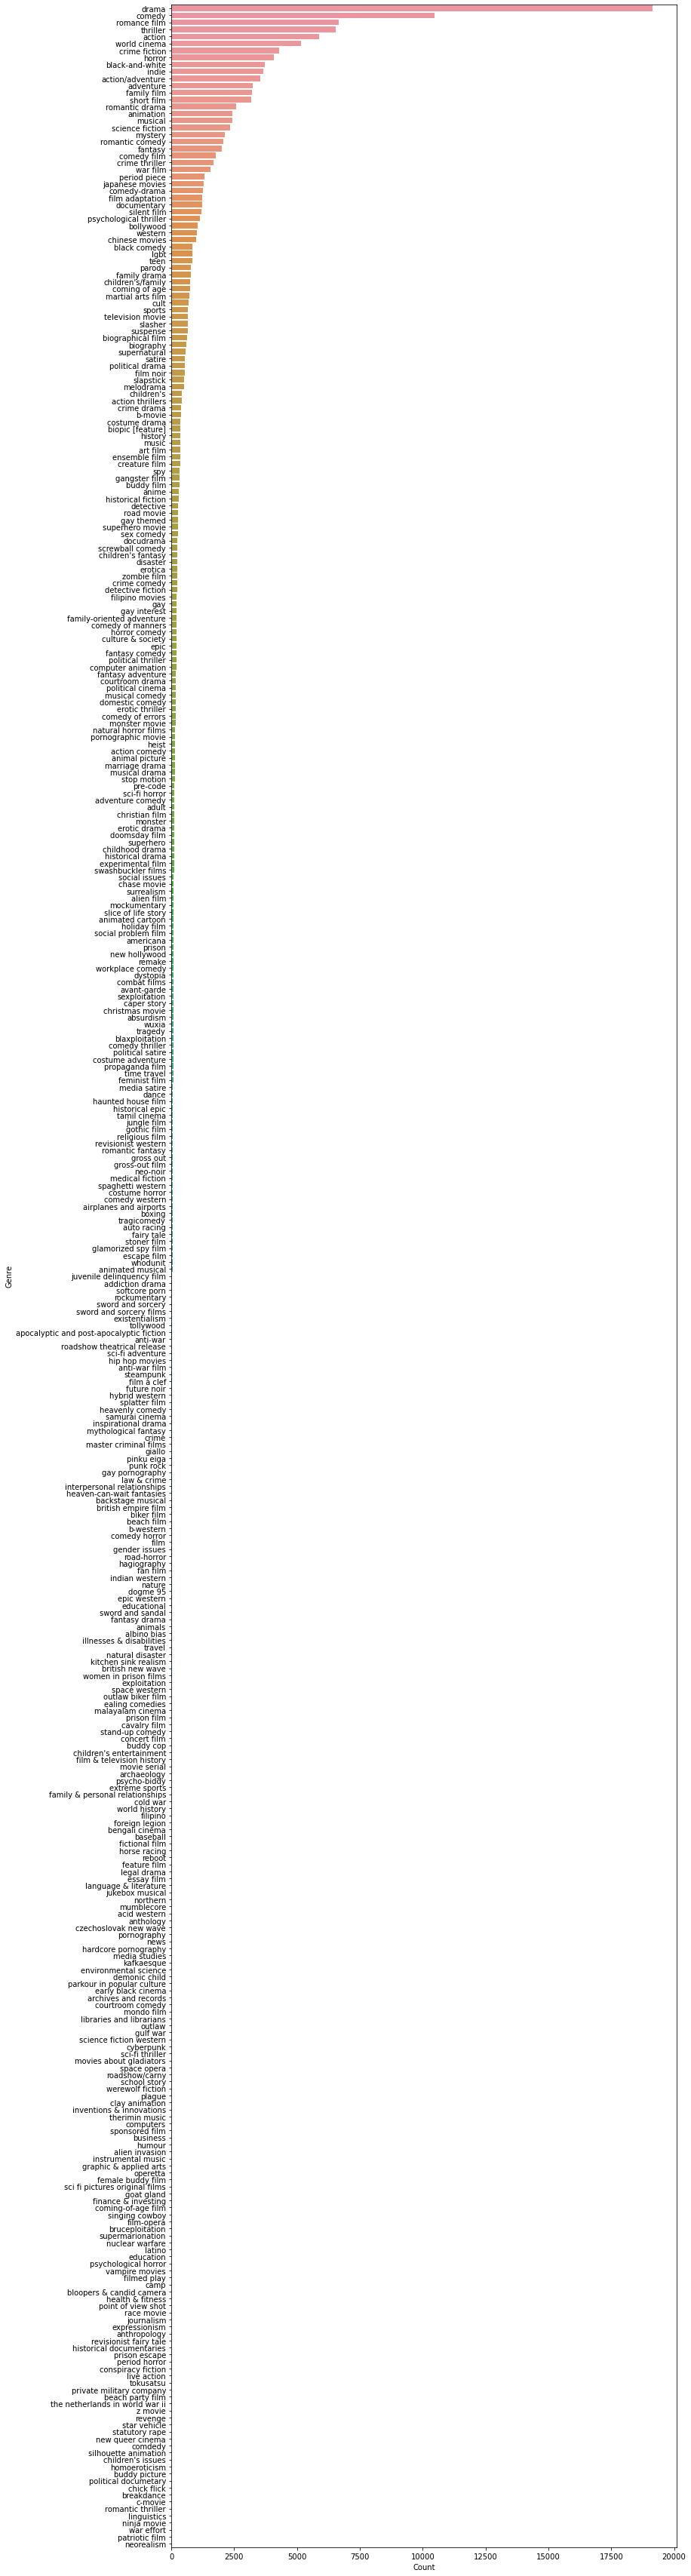

In [21]:
plot_freq(nbr_genre,all_genres_df)

In [22]:
g_less_than_200_movies=all_genres_df[all_genres_df['Count']<200].sort_values(by=['Count'])
percentage=round((g_less_than_200_movies.shape[0]/nbr_genre)*100,2)
percentage

74.93

Over 70 % of genre contain less than 200 movie. 
Can we just remove them from our analysis?

##### Note:
Here, we are extracting our samples of genre from this list , to set up our model, with a [purposive sampling](https://www.youtube.com/watch?v=CdK7N_kTzHI&feature=youtu.be) method (or judgmental/selective/subjective sampling). Thus, we are trying to use a set of criteria to get samples that would fit our questions/goals.

Because of that:
* The sampling is not random (not every genre had the same chance to be included in the sample)
* Our samples won't necessary be representative of the entire population we're interested to describe.

The first point won't affect negatively our results. However we have to avoid the second point in order to have a model that can work in real situation.

In [23]:
print(movies_new.iloc[4])

movie_id                                                 595909
movie_name                                    A Cry in the Dark
genre_new     [crime fiction, drama, docudrama, world cinema...
clean_plot    seventh day adventist church pastor michael ch...
Name: 4, dtype: object


We'll start by splitting dual-genres to avoid having, for example as above, a "drama" with a "courtroom drama". Therefore we'll split "courtroom drama" in 2 distinct genres: courtroom and drama. 

In [24]:
movies_new.head()

movie_id          movie_name  \
0  23890098          Taxi Blues   
1  31186339    The Hunger Games   
2  20663735          Narasimham   
3   2231378  The Lemon Drop Kid   
4    595909   A Cry in the Dark   

                                           genre_new  \
0                              [drama, world cinema]   
1  [action/adventure, science fiction, action, dr...   
2                [musical, action, drama, bollywood]   
3                         [screwball comedy, comedy]   
4  [crime fiction, drama, docudrama, world cinema...   

                                          clean_plot  
0  shlykov a hard working taxi driver and lyosha ...  
1  the nation of panem consists of a wealthy capi...  
2  poovalli induchoodan is sentenced for six year...  
3  the lemon drop kid a new york city swindler is...  
4  seventh day adventist church pastor michael ch...

In [25]:
# List dual genres
contains_space=all_genres_df["Genre"].str.contains(" ")
contains_bar=all_genres_df["Genre"].str.contains("/")

to_split=all_genres_df["Genre"][contains_space]
to_split2=all_genres_df["Genre"][contains_bar]

genre_to_split=pd.concat([to_split,to_split2])
genre_to_split[:10]

1         world cinema
3      science fiction
7     screwball comedy
9        crime fiction
11     courtroom drama
15     romantic comedy
16        media satire
20        romance film
21          short film
22         family film
Name: Genre, dtype: object

In [26]:
# Split dual genres - new_genre is a list
size_genre=len(new_genre)
for i in tqdm(genre_to_split):   # loop on the list containing the dual genres
    for s in range(size_genre):  # loop in new_genre list to get dual genre
        for g in new_genre[s]:   # loop on all genre related to a movie
            if g==i:             # if we get a dual-genre we split it and remove 
                if " " in g:
                    a=g.split(" ")
                    new_genre[s].remove(g)
                    for m in a:
                        if m not in new_genre[s]:
                            new_genre[s].append(m)
                elif "/" in g:
                    a=g.split("/")
                    new_genre[s].remove(g)
                    for m in a:
                        if m not in new_genre[s]:
                            new_genre[s].append(m)
new_genre[:10]

100%|████████████████████████████████████████| 250/250 [00:09<00:00, 25.70it/s]


[['drama', 'world', 'cinema'],
 ['action', 'drama', 'science', 'fiction', 'adventure'],
 ['musical', 'action', 'drama', 'bollywood'],
 ['comedy', 'screwball'],
 ['drama', 'docudrama', 'world', 'cinema', 'crime', 'fiction', 'courtroom'],
 ['thriller', 'action', 'drama', 'adventure'],
 ['thriller', 'drama', 'horror'],
 ['drama', 'teen'],
 ['americana',
  'comedy-drama',
  'black-and-white',
  'drama',
  'comedy',
  'romantic',
  'media',
  'satire',
  'romance',
  'film'],
 ['animation', 'short', 'film', 'family']]

In [27]:
# merging and removing information
# if we run this cell one cell we 
for t in (range(3)):
    size_genre=len(new_genre)
    for s in (tqdm(range(size_genre))):
        for g in new_genre[s]:
            l=new_genre[s]
            #print(l)
            if len(g)<2:
                l.remove(g)
            elif g=="coming":
                l.remove('coming')
                l.append("adult")
            elif g=="[feature]":
                l.remove('[feature]')
            elif g=="film" :
                l.remove('film')
            elif g=="cinema" :
                l.remove('cinema')
            elif g=="television" :
                l.remove('television')
            elif g=="movie" :
                l.remove('movie')
            elif g=="movies" :
                l.remove('movies')
            elif g=="arts" :
                l.remove('arts')
            elif g=="gay" :
                l.remove('gay')
                if "lgbt" not in l:
                    l.append("lgbt")
            elif g=="comedy-drama" :
                l.remove('comedy-drama')
                if "comedy" not in l:
                    l.append("comedy")
                if "drama" not in l:
                    l.append("drama")
            elif g=="romantic" :
                l.remove('romantic')
                if "romance" not in l:
                    l.append("romance")
            elif g=="indie" :
                l.remove('indie')
                if "bollywood" not in l:
                    l.append("bollywood")
            elif g=="martial" :
                l.remove('martial')
                if "action" not in l:
                    l.append("action")
            elif g=="period" :
                l.remove('period')
                l.append("period-piece")
            elif g=="piece" :
                l.remove('piece')
            elif g=="of" :
                l.remove('of')
            elif g=="and" :
                l.remove('and')
            elif g=="age" :
                l.remove('age')
            elif g=="biographical" :
                l.remove('biographical')
                if "biopic" not in l:
                    l.append("biopic")
            elif g=="biography" :
                l.remove('biography')
                if "biopic" not in l:
                    l.append("biopic")
            elif g=="melodrama" :
                l.remove('melodrama')
                if "drama" not in l:
                    l.append("drama")
            elif "children's" in g :
                l.remove("children's")
                if "family" not in l:
                    l.append("family")
            elif g=="noir" :
                l.remove("noir")
                if "black" not in l:
                    l.append("black")
            elif g=="thrillers" :
                l.remove("thrillers")
                if "thriller" not in l:
                    l.append("thriller") 

100%|████████████████████████████████| 41793/41793 [00:00<00:00, 114501.29it/s]


In [28]:
new_genre[:10]

[['drama', 'world'],
 ['action', 'drama', 'science', 'fiction', 'adventure'],
 ['musical', 'action', 'drama', 'bollywood'],
 ['comedy', 'screwball'],
 ['drama', 'docudrama', 'world', 'crime', 'fiction', 'courtroom'],
 ['thriller', 'action', 'drama', 'adventure'],
 ['thriller', 'drama', 'horror'],
 ['drama', 'teen'],
 ['americana',
  'black-and-white',
  'drama',
  'comedy',
  'media',
  'satire',
  'romance'],
 ['animation', 'short', 'family']]

In [29]:
all_genres_without_dual,all_genres_without_dual_unique = unique_genres(new_genre)

In [30]:
print(len(all_genres_without_dual_unique))
all_genres_without_dual[:15]

360


['drama',
 'world',
 'action',
 'drama',
 'science',
 'fiction',
 'adventure',
 'musical',
 'action',
 'drama',
 'bollywood',
 'comedy',
 'screwball',
 'drama',
 'docudrama']

In [31]:
all_genres_df_wd = genres_list_to_df(all_genres_without_dual)
print(all_genres_df_wd.sort_values(by=['Count'],ascending=False)[:10])
print("\n")
print(all_genres_df_wd.sort_values(by=['Count'],ascending=False)[-10:])

        Genre  Count
0       drama  19813
8      comedy  12890
20    romance   7254
4     fiction   6984
13   thriller   6907
2      action   6885
5   adventure   6101
1       world   5164
11      crime   5146
7   bollywood   4723


            Genre  Count
347         chick      1
348         flick      1
331    documetary      1
346    breakdance      1
342       c-movie      1
246        effort      1
288         movie      1
337   linguistics      1
336  biographical      1
359    neorealism      1


With the information above, we want to remove all genre with less than 300 movies (purpose sampling).

* Is it a good choice? 
* And will the samples we'll obtain be representative of our population (which is the main genres that a movie can have)

We'll use the genres of movies from the Netflix platform to compare with what we have.

The file loaded is from a web scrapind of this [site](https://instantwatcher.com/genres/all)

In [32]:
#load genre movies from Netfix
genre_netflix= pd.read_csv("out_genre_netfix.csv")
genre_netflix

genre  count
0         Action & Adventure    493
1                      Anime    235
2   Children & Family Movies    356
3             Classic Movies     53
4                   Comedies   1335
5                Cult Movies     36
6              Documentaries    824
7                     Dramas   1472
8       Faith & Spirituality     53
9       Gay & Lesbian Movies     84
10             Horror Movies    241
11        Independent Movies    459
12      International Movies   1704
13                     Music    143
14             Period Pieces    144
15           Romantic Movies    556
16          Sci-Fi & Fantasy    234
17          Sports & Fitness     90
18                  TV Shows   3304
19                 Thrillers    349

Here we have 20 main genres. And we can find each of them in the list that we'll have after deleting genres with less than 300 movies. 

Thus, we can be confident about our list and his representation of the population.

In [33]:
# Count movie by genre
count = all_genres_df_wd[all_genres_df_wd["Count"]<300].shape[0]
print("Genres with less than 300 movie(s) = ",count)

Genres with less than 300 movie(s) =  305


In [34]:
# Removing genre with less than 300 movies
size_genre=len(new_genre)
for i in all_genres_df_wd["Genre"][all_genres_df["Count"]<300]:
    for s in range(size_genre):
        for g in new_genre[s]:
            if g== i:
                new_genre[s].remove(g)
print("Done")

Done


In [35]:
all_genres_clean,all_genres_clean_unique = unique_genres(new_genre)

In [36]:
# Last list of movie's genre 
nbr_genre_clean=len(all_genres_clean_unique)
print(nbr_genre_clean)

71


In [37]:
# plot the new freq 
all_genres_df_wd_m_300=all_genres_df_wd[all_genres_df_wd["Count"]>300]
plot_freq(nbr_genre_clean,all_genres_df_wd_m_300)

In [38]:
# add new_genre to 'movies' dataframe  
movies_new['genre_new']=new_genre
movies_new

movie_id                       movie_name  \
0      23890098                       Taxi Blues   
1      31186339                 The Hunger Games   
2      20663735                       Narasimham   
3       2231378               The Lemon Drop Kid   
4        595909                A Cry in the Dark   
...         ...                              ...   
42199  34808485              Oomakkuyil Padumbol   
42200   1096473                 The Last Command   
42201  35102018  Randy Parsons: American Luthier   
42202   8628195                       Kabuliwala   
42203   6040782                       Dad's Army   

                                          genre_new  \
0                                    [drama, world]   
1      [action, drama, science, fiction, adventure]   
2                          [musical, action, drama]   
3                               [comedy, screwball]   
4                [drama, world, fiction, courtroom]   
...                                             ...   
42199                                      [family]   
42200      [drama, political, silent, period-piece]   
42201                   [music, documentary, short]   
42202                                       [drama]   
42203                                      [comedy]   

                                              clean_plot  
0      shlykov a hard working taxi driver and lyosha ...  
1      the nation of panem consists of a wealthy capi...  
2      poovalli induchoodan is sentenced for six year...  
3      the lemon drop kid a new york city swindler is...  
4      seventh day adventist church pastor michael ch...  
...                                                  ...  
42199  the story is about reema a young muslim school...  
42200  in hollywood director leo andreyev looks throu...  
42201  american luthier focuses on randy parsons tran...  
42202  abdur rehman khan a middle aged dry fruit sell...  
42203  operation dynamo has just taken place from the...  

[41793 rows x 4 columns]

In [39]:
# remove samples with 0 genre tags
print("Before :",movies_new.shape)
movies_new = movies_new[~(movies_new['genre_new'].str.len() == 0)]
print("After :",movies_new.shape)

Before : (41793, 4)
After : (40905, 4)


Now we'll analyze the plot summaries data.

#### Plot summaries analysis

In [40]:
movies_new['clean_plot'].head()

0    shlykov a hard working taxi driver and lyosha ...
1    the nation of panem consists of a wealthy capi...
2    poovalli induchoodan is sentenced for six year...
3    the lemon drop kid a new york city swindler is...
4    seventh day adventist church pastor michael ch...
Name: clean_plot, dtype: object

All the text above is in lowercase and there are also no punctuation marks

With the function below, we will visualize the words and their frequency in a set of documents in order to find out the most frequent words in the movie plots column:

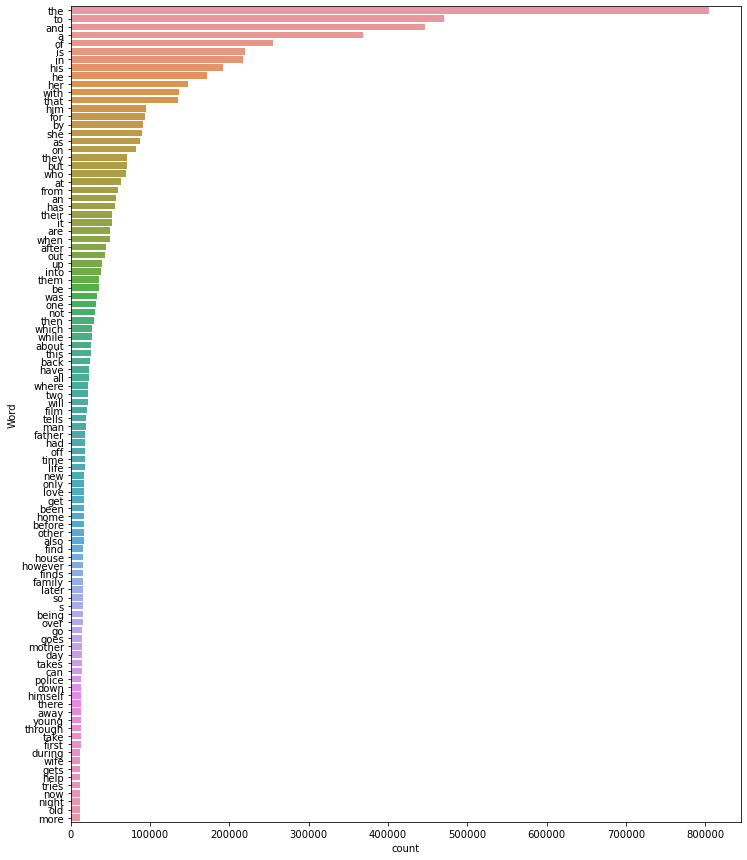

In [41]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  
 # print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

Most of the terms in the above plot are stopwords. These stopwords carry far less meaning than other keywords in the text (they just add noise to the data). We'll remove them from the plots’ text. 

First at all we need to download the list of stopwords from the nltk library:

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kapetaJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
#Remove the stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

C:\ProgramData\Anaconda2\envs\p36workshop\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [44]:
freq_words(movies_new['clean_plot'], 100)

More interesting and meaningful words have now emerged, such as “police”, “family”, “money”, “city”, and so on.

In [45]:
#save the cleaned data to a CSV file
movies_new.to_csv('movies_new.csv')

### Converting Genres to Features
We treat this multi-label classification problem as a Binary Relevance problem. Hence, we transform with now one-hot encoding the column genre_new by using sklearn’s **MultiLabelBinarizer( )**. Since there are 71 unique genre tags, there are going to be 71 new target variables.

In [46]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])
print(y.shape)

(40905, 71)


We're ready to move on the AI part of this work. As a reminder the question we want to anwser is:
**Can we predict the genre of a movie based on its synopsis?**

## Build Your Movie Genre Prediction Model
We are all set for the model building part! This is what we’ve been waiting for.

Remember, we will have to build a model for every one-hot encoded target variable. Since we have 71 target variables, we will have to fit 71 different models with the same set of predictors (TF-IDF features). Training models can take a considerable amount of time on a modest system. 

It's why we'll use Logistic Regression model. It is quick to train on limited computational power.

We'll start by extracting features from the cleaned version of the movie plots data. For this article, we will be using TF-IDF features. However we can use other feature extraction method  such as Bag-of-Words, word2vec, GloVe, or ELMo.

Here an exemple with [Glove on Kaggle](https://www.kaggle.com/eswarbabu88/toxic-comment-glove-logistic-regression/code)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [48]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000)

We have used the 20,000 most frequent words in the data as features. It is a arbitrary choice. In another iteration of this project, we'll try to define a robust method for this paramater.

In [49]:
X=movies_new['clean_plot']

In [50]:
print(X.shape,y.shape)

(40905,) (40905, 71)


Now, before creating TF-IDF features, we will split our data into train and validation sets for training and evaluating our model’s performance. We'll use a 80-20 split – 80% of the data samples in the train set and the rest in the validation set

In [51]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# create TF-IDF features for the train and the validation set
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [53]:
print(xtrain_tfidf.shape,"/",xval_tfidf.shape)

(32724, 20000) / (8181, 20000)


In [54]:
print(xtrain_tfidf[0])

  (0, 2554)	0.020013811222501843
  (0, 16228)	0.016897626192284108
  (0, 7711)	0.016662377024184053
  (0, 14014)	0.01919166248783705
  (0, 4133)	0.02095022494691453
  (0, 13565)	0.02086094801317103
  (0, 12243)	0.021157929449021076
  (0, 13332)	0.013777433336875916
  (0, 12442)	0.01889131786243037
  (0, 16340)	0.03185859179451622
  (0, 17095)	0.021611592329731175
  (0, 6628)	0.009826566277954859
  (0, 16012)	0.021979853104525042
  (0, 15938)	0.02434846541374908
  (0, 14463)	0.018057699620708526
  (0, 1159)	0.02352055792676223
  (0, 4595)	0.022901382066001365
  (0, 4156)	0.019923487647112107
  (0, 13912)	0.029996658950766013
  (0, 4590)	0.032814227777986954
  (0, 3386)	0.02708055255778625
  (0, 6178)	0.019959396398222626
  (0, 18552)	0.014610237716053256
  (0, 2797)	0.017318967945798746
  (0, 10059)	0.010800291568087213
  :	:
  (0, 5101)	0.02822941087882057
  (0, 17160)	0.019637847346706018
  (0, 5713)	0.03298142565508465
  (0, 1132)	0.031658774035045065
  (0, 8027)	0.01691799504615927


We will use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem

In [55]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [56]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [57]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [58]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [59]:
y_pred[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

It is a binary one-dimensional array of length 71. Basically, it is the one-hot encoded form of the unique genre tags. To convert it into movie genre tags,we'll use the inverse_transform( ) function from sk-learn along with the MultiLabelBinarizer( ) object

In [60]:
multilabel_binarizer.inverse_transform(y_pred)[2]

('comedy', 'drama', 'romance')

#### Evalution

In [61]:
# evaluate performance for a threshold=0,5
f1_score(yval, y_pred, average="micro")

0.4320942662779398

We get a decent F1 score of 0.43. 

Let’s try to change this threshold value and see if that improves our model’s score:


In [62]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.5455601505506249

#### Prediction

In [63]:
# Get back our tags of genre
genres = np.asarray(multilabel_binarizer.classes_)

In [64]:
from sklearn.metrics import classification_report
print(classification_report(yval, y_pred, target_names=genres))

                 precision    recall  f1-score   support

         action       0.74      0.34      0.46      1415
     adaptation       0.00      0.00      0.00       252
          adult       0.00      0.00      0.00       155
      adventure       0.71      0.28      0.40      1225
      animation       0.74      0.27      0.39       489
          anime       0.00      0.00      0.00        65
        b-movie       0.00      0.00      0.00        86
          beach       0.00      0.00      0.00         3
          black       0.00      0.00      0.00       266
          buddy       0.00      0.00      0.00        72
          chase       0.00      0.00      0.00        27
        chinese       0.85      0.17      0.28       206
      christian       0.00      0.00      0.00        21
         comedy       0.72      0.45      0.56      2546
       computer       0.00      0.00      0.00        40
        costume       0.00      0.00      0.00        85
      courtroom       0.00    

C:\ProgramData\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda2\envs\p36workshop\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see, the performance is by and large poorer for movies which are less represented like adaptation and wuxia, and better for categories like Drama.

In [65]:
# Function to predict the most X probable values of genre
def get_genres_predicted(movie,nbr):
    ind=y_pred_prob[movie].argsort()[-nbr:][::-1]
    print(genres[ind])

In [66]:
# Fucntion to get the real genres
def get_real_genre(movie):
    f_genres=multilabel_binarizer.inverse_transform(yval)[movie]
    print(f_genres)

In [67]:
# Evalution
get_genres_predicted(4232,5)
get_real_genre(4232)
print("\n")
get_genres_predicted(1265,5)
get_real_genre(1265)
print("\n")
get_genres_predicted(67,5)
get_real_genre(67)

['romance' 'comedy' 'drama' 'world' 'chinese']
('action', 'adventure', 'chinese', 'comedy', 'romance', 'world')


['drama' 'romance' 'comedy' 'action' 'thriller']
('drama', 'fiction', 'romance', 'thriller')


['drama' 'romance' 'comedy' 'silent' 'fiction']
('drama',)


In [68]:
# Evaluation
get_genres_predicted(5,5)
get_real_genre(5)
print("\n")
get_genres_predicted(100,5)
get_real_genre(100)
print("\n")
get_genres_predicted(2000,5)
get_real_genre(2000)


['drama' 'adventure' 'action' 'fiction' 'science']
('adventure', 'drama', 'fiction', 'silent')


['drama' 'comedy' 'romance' 'world' 'musical']
('comedy', 'romance')


['comedy' 'animation' 'short' 'family' 'adventure']
('action', 'adventure', 'comedy', 'cult', 'family', 'family-oriented', 'musical')
